In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb

df = pd.read_csv('AmesHousing.csv', sep='\t')
pd.set_option('display.max_columns', None)
new_df = df.assign(hasBasement = df['Total Bsmt SF'] > 0)
new_df = new_df.assign(hasGarage = df['Garage Area'] > 0)
new_df = new_df.assign(hasFireplace = df['Fireplaces'] > 0)
new_df = new_df.assign(hasPool = df['Pool Area'] > 0)
new_df = new_df.assign(TotalSF = (df['Total Bsmt SF'].fillna(0) + df['Gr Liv Area'].fillna(0)))
new_df = new_df.assign(TotalBath = (df['Bsmt Full Bath'].fillna(0) + 0.5 * df['Bsmt Half Bath'].fillna(0) + 
                                   df['Full Bath'].fillna(0) + 0.5 * df['Half Bath'].fillna(0)))
new_df = new_df.assign(TotalPorchSF = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
new_df = new_df.assign(Positive_Off_Site = (df['Condition 2'] == 'PosN') | (df['Condition 2'] == 'PosA'))
new_df = new_df.assign(hasFence = df['Fence'].notnull())

new_df.drop(columns=['Total Bsmt SF', 'Fireplaces',
                    'Pool Area', 'Bsmt Exposure', 'Bsmt Half Bath',
                    'Bsmt Full Bath', 'BsmtFin Type 1', 'BsmtFin Type 2',
                    'Bsmt Exposure', 'Lot Config', 'Condition 2',
                    'Garage Type', 'Garage Finish', 'Garage Qual',
                    'Pool QC', 'Fence', 'Lot Shape', 'Land Slope',
                    'Fireplace Qu', 'Yr Sold',
                    'Mo Sold', 'Order', '1st Flr SF', '2nd Flr SF'
                    , 'Garage Yr Blt', 'Garage Cond', 'Wood Deck SF'
                    , 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                    'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF']
                    ,inplace=True)
new_df = new_df[new_df['Electrical'].notnull()]

print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2929 entries, 0 to 2929
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PID                2929 non-null   int64  
 1   MS SubClass        2929 non-null   int64  
 2   MS Zoning          2929 non-null   object 
 3   Lot Frontage       2439 non-null   float64
 4   Lot Area           2929 non-null   int64  
 5   Street             2929 non-null   object 
 6   Alley              198 non-null    object 
 7   Land Contour       2929 non-null   object 
 8   Utilities          2929 non-null   object 
 9   Neighborhood       2929 non-null   object 
 10  Condition 1        2929 non-null   object 
 11  Bldg Type          2929 non-null   object 
 12  House Style        2929 non-null   object 
 13  Overall Qual       2929 non-null   int64  
 14  Overall Cond       2929 non-null   int64  
 15  Year Built         2929 non-null   int64  
 16  Year Remod/Add     2929 non-n

In [68]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [69]:
price_quartiles = new_df['SalePrice'].quantile([0.25, 0.5, 0.75])
print("\nPrice Quartiles:")
print(f"Q1 (25%): ${price_quartiles[0.25]:,.0f}")
print(f"Q2 (50%): ${price_quartiles[0.5]:,.0f}")
print(f"Q3 (75%): ${price_quartiles[0.75]:,.0f}")

def categorize_price(price):
    if price < price_quartiles[0.25]:
        return 'Low'
    elif price < price_quartiles[0.5]:
        return 'Medium-Low'
    elif price < price_quartiles[0.75]:
        return 'Medium-High'
    else:
        return 'High'

new_df['PriceCategory'] = new_df['SalePrice'].apply(categorize_price)
print(new_df['PriceCategory'].value_counts().sort_index())


Price Quartiles:
Q1 (25%): $129,500
Q2 (50%): $160,000
Q3 (75%): $213,500
PriceCategory
High           734
Low            731
Medium-High    751
Medium-Low     713
Name: count, dtype: int64


In [70]:
X = new_df.drop(columns=['SalePrice', 'PriceCategory', 'PID'])
y = new_df['PriceCategory']

X_cat = X.copy()
categorical_cols = X_cat.select_dtypes(include=['object']).columns
bool_cols = X_cat.select_dtypes(include=['bool']).columns

if len(bool_cols) > 0:
    X_cat[bool_cols] = X_cat[bool_cols].astype(bool)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X[bool_cols] = X[bool_cols].astype(int)

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class labels: {y_encoder.classes_}")

Number of features: 55
Number of classes: 4
Class labels: ['High' 'Low' 'Medium-High' 'Medium-Low']


In [71]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(
    X, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train_10.shape[0]}")
print(f"Test set: {X_test_10.shape[0]}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train_10, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"{cls}: {cnt} ({cnt/len(y_train_10)*100:.1f}%)")

lgb_train_10 = lgb.Dataset(X_train_10, y_train_10)

params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_encoded)),
    'max_depth': 6,
    'learning_rate': 0.1,
    'num_leaves': 50,  
    'n_estimators': 100,
    'random_state': 42,
    'verbose': -1
}

lgb_model_10_strat = lgb.train(params, lgb_train_10, num_boost_round=100)

y_pred_10_strat = np.argmax(lgb_model_10_strat.predict(X_test_10), axis=1)

print(f"\nAccuracy:  {accuracy_score(y_test_10, y_pred_10_strat):.4f}")
print(f"Precision: {precision_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")


Training set: 2636
Test set: 293

Class distribution in training set:
High: 660 (25.0%)
Low: 658 (25.0%)
Medium-High: 676 (25.6%)
Medium-Low: 642 (24.4%)

Accuracy:  0.7952
Precision: 0.7952
Recall:    0.7952
F1 Score:  0.7951


In [72]:
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_encoded)),
    'max_depth': 6,
    'learning_rate': 0.1,
    'num_leaves': 50,
    'min_data_in_leaf': 20,  
    'min_gain_to_split': 0.001,
    'feature_fraction': 0.8,  # Use 80% of features in each iteration
    'bagging_fraction': 0.8,  # Use 80% of data in each iteration
    'bagging_freq': 1,  
    'random_state': 42,
    'verbose': -1  
}

lgb_train_10 = lgb.Dataset(X_train_10, y_train_10)
lgb_val_10 = lgb.Dataset(X_test_10, y_test_10, reference=lgb_train_10)

lgb_model_10_strat = lgb.train(
    params, 
    lgb_train_10,
    num_boost_round=1000,
    valid_sets=[ lgb_train_10, lgb_val_10]
)

y_pred_10_strat = np.argmax(lgb_model_10_strat.predict(X_test_10), axis=1)

print(f"Accuracy:  {accuracy_score(y_test_10, y_pred_10_strat):.4f}")
print(f"Precision: {precision_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")

Accuracy:  0.7884
Precision: 0.7889
Recall:    0.7884
F1 Score:  0.7885


In [73]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train_20.shape[0]}")
print(f"Test set: {X_test_20.shape[0]}")

print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train_20, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"{cls}: {cnt} ({cnt/len(y_train_20)*100:.1f}%)")

lgb_train_20 = lgb.Dataset(X_train_20, y_train_20)

lgb_model_20_strat = lgb.train(params, lgb_train_20, num_boost_round=100)

y_pred_20_strat = np.argmax(lgb_model_20_strat.predict(X_test_20), axis=1)

print(f"\nAccuracy:  {accuracy_score(y_test_20, y_pred_20_strat):.4f}")
print(f"Precision: {precision_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")


Training set: 2343
Test set: 586

Class distribution in training set:
High: 587 (25.1%)
Low: 585 (25.0%)
Medium-High: 601 (25.7%)
Medium-Low: 570 (24.3%)

Accuracy:  0.8157
Precision: 0.8149
Recall:    0.8157
F1 Score:  0.8152


In [74]:
lgb_train_20 = lgb.Dataset(X_train_20, y_train_20)
lgb_val_20 = lgb.Dataset(X_test_20, y_test_20, reference=lgb_train_20)

lgb_model_20_strat = lgb.train(
    params, 
    lgb_train_20,
    num_boost_round=1000,
    valid_sets=[lgb_train_20, lgb_val_20]
)

y_pred_20_strat = np.argmax(lgb_model_20_strat.predict(X_test_20), axis=1)

print(f"\nAccuracy:  {accuracy_score(y_test_20, y_pred_20_strat):.4f}")
print(f"Precision: {precision_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")


Accuracy:  0.8225
Precision: 0.8228
Recall:    0.8225
F1 Score:  0.8227


In [75]:
X_train_20_no, X_test_20_no, y_train_20_no, y_test_20_no = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=None
)

print(f"\nClass distribution in training set (no stratification):")
unique, counts = np.unique(y_train_20_no, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"  {cls}: {cnt} ({cnt/len(y_train_20_no)*100:.1f}%)")

lgb_train_20_no = lgb.Dataset(X_train_20_no, y_train_20_no)

lgb_model_20_no_strat = lgb.train(params, lgb_train_20_no, num_boost_round=100)

y_pred_20_no_strat = np.argmax(lgb_model_20_no_strat.predict(X_test_20_no), axis=1)

print(f"\nAccuracy:  {accuracy_score(y_test_20_no, y_pred_20_no_strat):.4f}")
print(f"Precision: {precision_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")


Class distribution in training set (no stratification):
  High: 587 (25.1%)
  Low: 583 (24.9%)
  Medium-High: 615 (26.2%)
  Medium-Low: 558 (23.8%)

Accuracy:  0.8225
Precision: 0.8225
Recall:    0.8225
F1 Score:  0.8224


In [76]:
lgb_train_20_no = lgb.Dataset(X_train_20_no, y_train_20_no)
lgb_val_20_no = lgb.Dataset(X_test_20_no, y_test_20_no, reference=lgb_train_20_no)

lgb_model_20_no_strat = lgb.train(
    params, 
    lgb_train_20_no,
    num_boost_round=1000,
    valid_sets=[lgb_train_20_no, lgb_val_20_no]
)

y_pred_20_no_strat = np.argmax(lgb_model_20_no_strat.predict(X_test_20_no), axis=1)

print(f"\nAccuracy:  {accuracy_score(y_test_20_no, y_pred_20_no_strat):.4f}")
print(f"Precision: {precision_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")


Accuracy:  0.8311
Precision: 0.8320
Recall:    0.8311
F1 Score:  0.8312


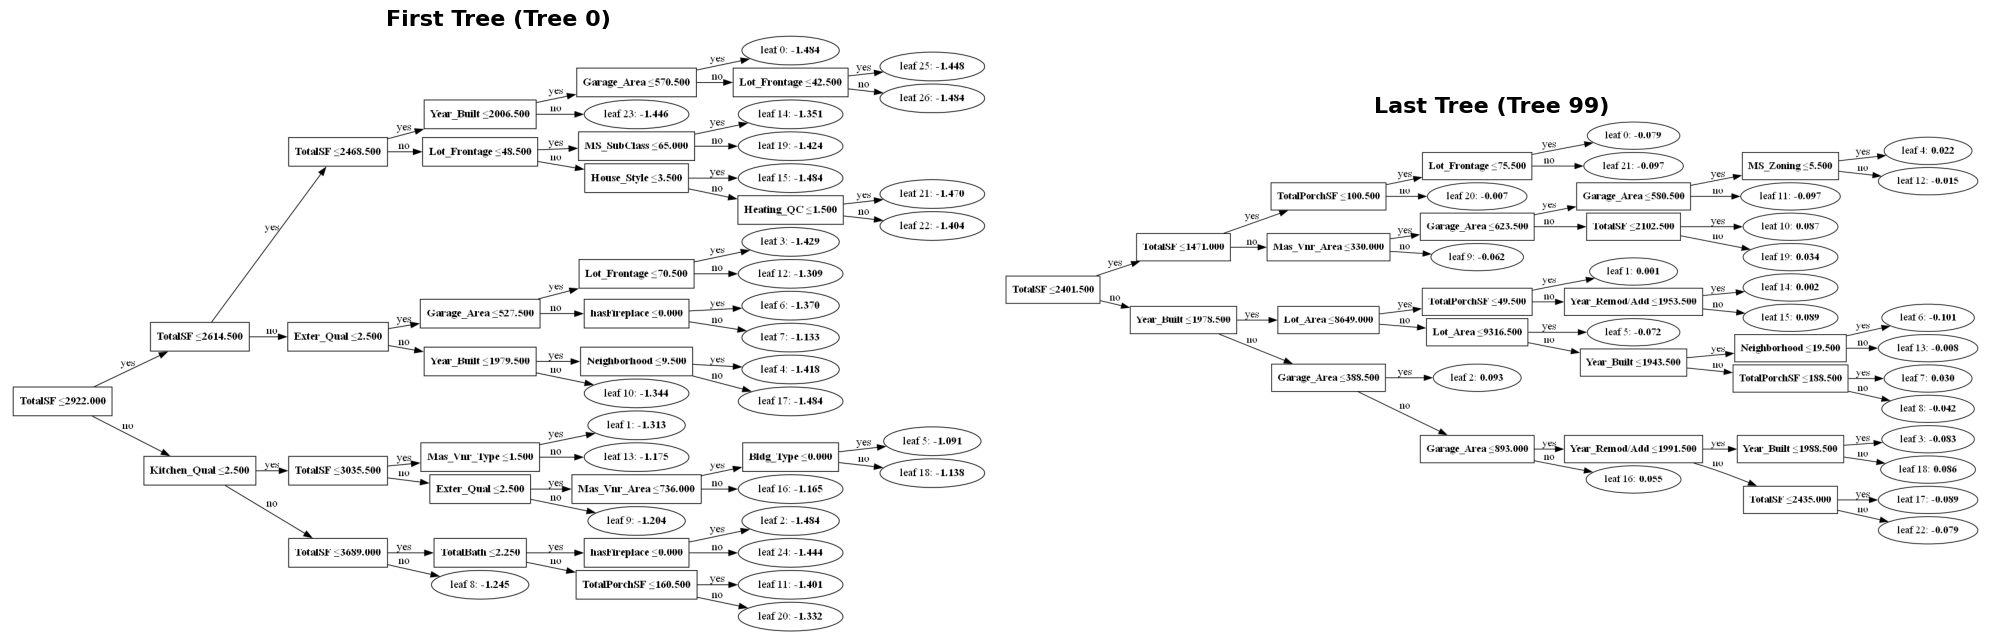

In [77]:
def visualize_tree_in_memory(model, tree_index, title, ax=None):
    try:
        graph = lgb.create_tree_digraph(model, tree_index=tree_index)
        
        png_data = graph.pipe(format='png')
        
        import io
        import matplotlib.image as mpimg
        img = mpimg.imread(io.BytesIO(png_data), format='png')
        
        if ax is None:
            ax = plt.gca()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title, fontsize=16, fontweight='bold')
    except Exception as e:
        if ax is None:
            ax = plt.gca()
        ax.axis('off')
        ax.text(0.5, 0.5, f"Tree visualization failed:\n{e}",
                ha='center', va='center', fontsize=12)

fig, axes = plt.subplots(1, 2, figsize=(20, 12))
visualize_tree_in_memory(lgb_model_20_strat, 0, 'First Tree (Tree 0)', ax=axes[0])
visualize_tree_in_memory(lgb_model_20_strat, 99, 'Last Tree (Tree 99)', ax=axes[1])

plt.tight_layout()
plt.show()


       Feature  Importance
       TotalSF        4101
      Lot Area        4014
   Gr Liv Area        3618
   Garage Area        3452
  Lot Frontage        3428
    Year Built        2723
  TotalPorchSF        2453
Year Remod/Add        2437
  Mas Vnr Area        1521
  Neighborhood        1506
     TotalBath        1056
  Overall Qual         939
  Overall Cond         909
  Exterior 2nd         792
  Exterior 1st         759


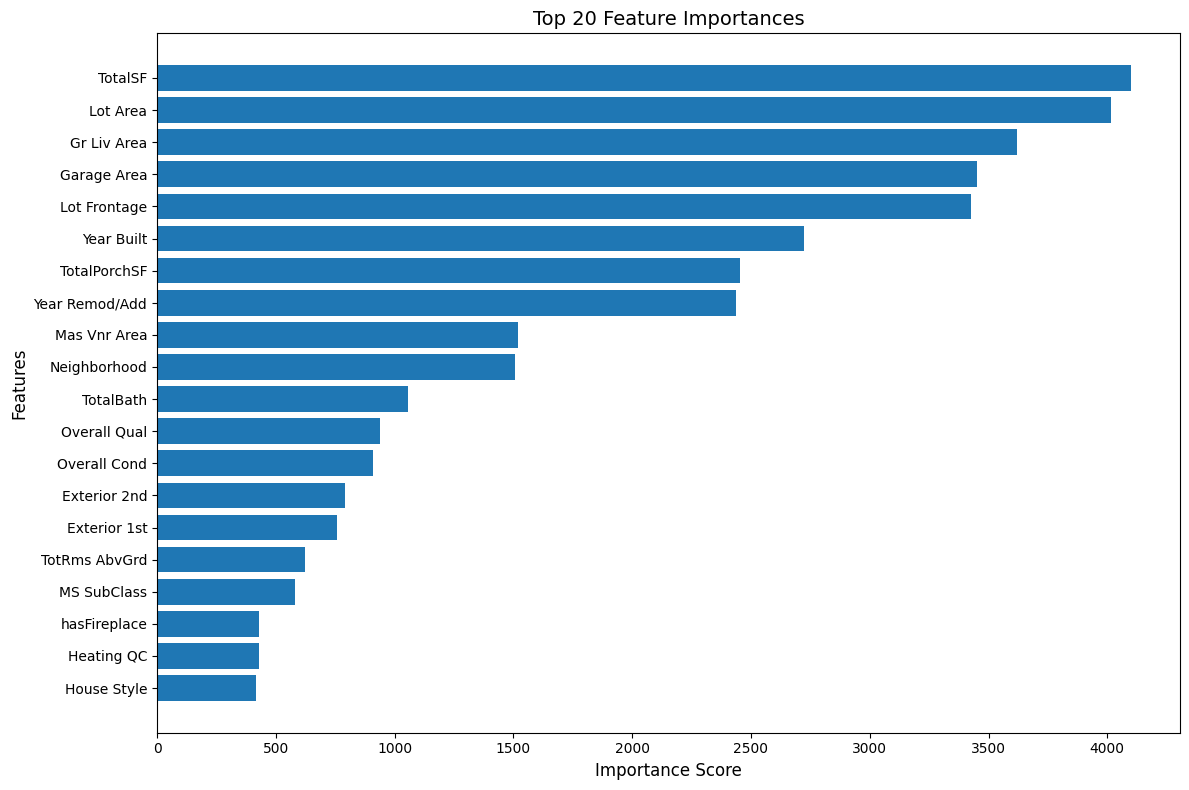

In [78]:
feature_importance = lgb_model_20_no_strat.feature_importance()
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(importance_df.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_n = 20
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Feature Importances', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

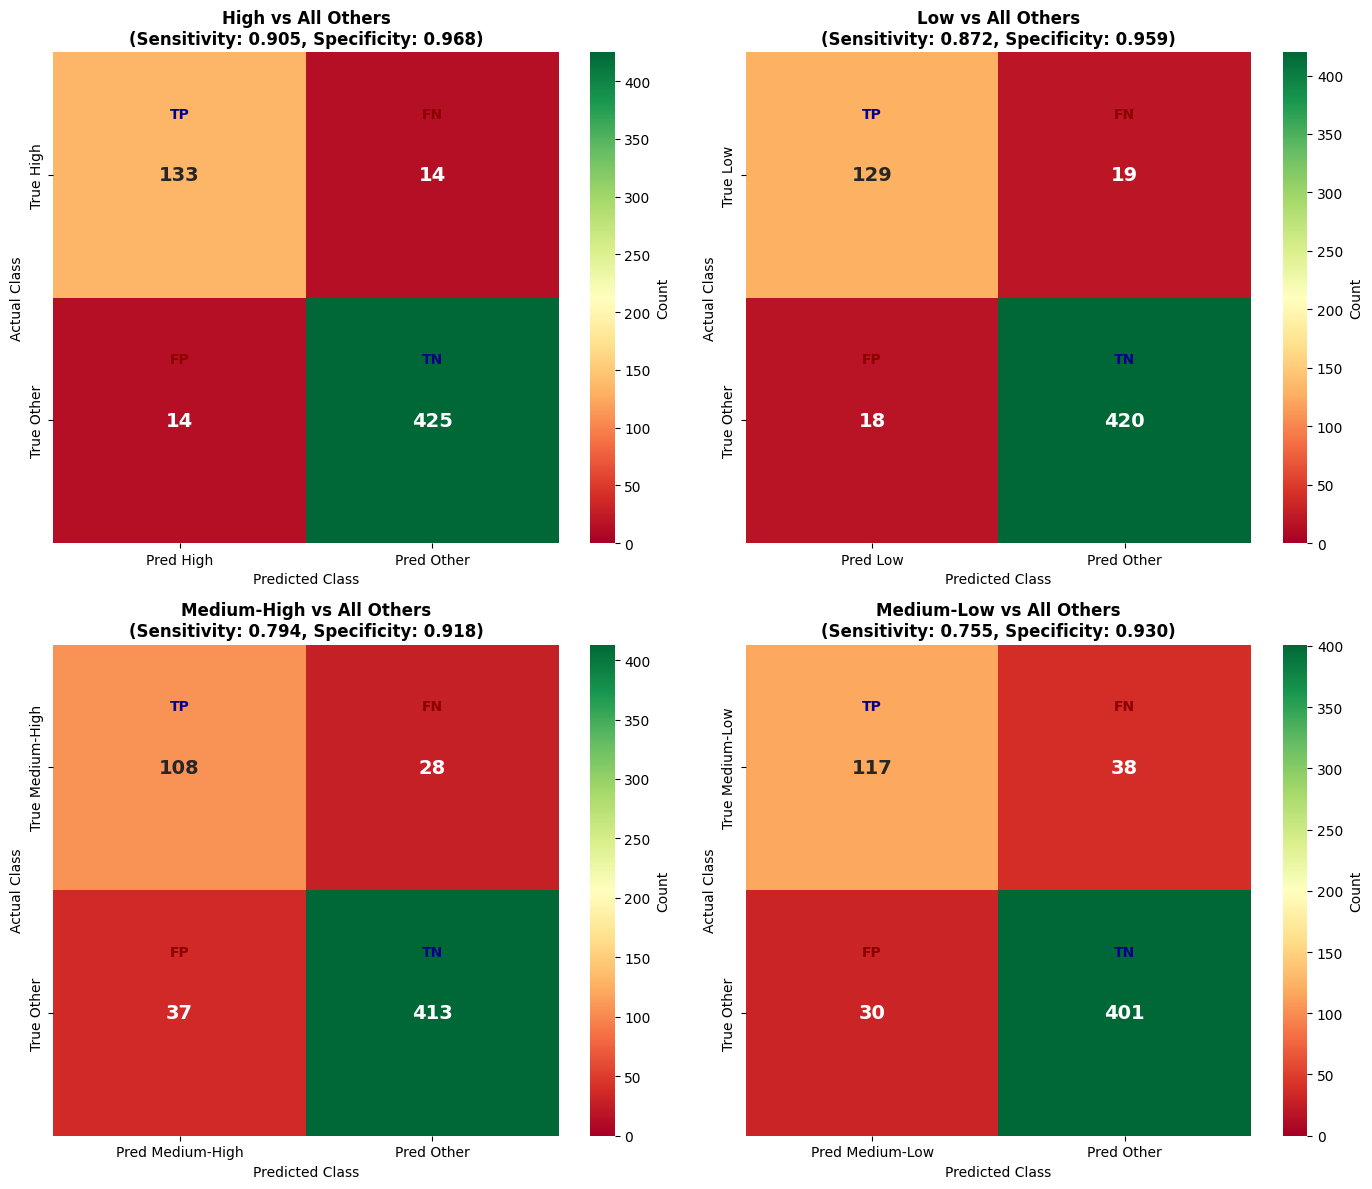

In [86]:
def calculate_binary_metrics(y_true, y_pred, class_idx):
    y_true_binary = (y_true == class_idx).astype(int)
    y_pred_binary = (y_pred == class_idx).astype(int)
    
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    
    return tp, fp, fn, tn

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, class_name in enumerate(y_encoder.classes_):
    tp, fp, fn, tn = calculate_binary_metrics(y_test_20_no, y_pred_20_no_strat, idx)
    binary_cm = np.array([[tp, fn], [fp, tn]])
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sns.heatmap(binary_cm, annot=True, fmt='d', cmap='RdYlGn', ax=axes[idx],
                xticklabels=[f'Pred {class_name}', 'Pred Other'],
                yticklabels=[f'True {class_name}', 'True Other'],
                cbar_kws={'label': 'Count'}, vmin=0, vmax=max(tp, fp, fn, tn),
                annot_kws={'size': 14, 'weight': 'bold'})
    
    axes[idx].text(0.5, 0.25, 'TP', ha='center', va='center', 
                   fontsize=10, color='darkblue', weight='bold')
    axes[idx].text(1.5, 0.25, 'FN', ha='center', va='center', 
                   fontsize=10, color='darkred', weight='bold')
    axes[idx].text(0.5, 1.25, 'FP', ha='center', va='center', 
                   fontsize=10, color='darkred', weight='bold')
    axes[idx].text(1.5, 1.25, 'TN', ha='center', va='center', 
                   fontsize=10, color='darkblue', weight='bold')
    
    axes[idx].set_title(f'{class_name} vs All Others\n(Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f})', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual Class', fontsize=10)
    axes[idx].set_xlabel('Predicted Class', fontsize=10)

plt.tight_layout()
plt.show()

In [80]:
print(classification_report(y_test_20_no, y_pred_20_no_strat, target_names=y_encoder.classes_))

              precision    recall  f1-score   support

        High       0.90      0.90      0.90       147
         Low       0.88      0.87      0.87       148
 Medium-High       0.74      0.79      0.77       136
  Medium-Low       0.80      0.75      0.77       155

    accuracy                           0.83       586
   macro avg       0.83      0.83      0.83       586
weighted avg       0.83      0.83      0.83       586



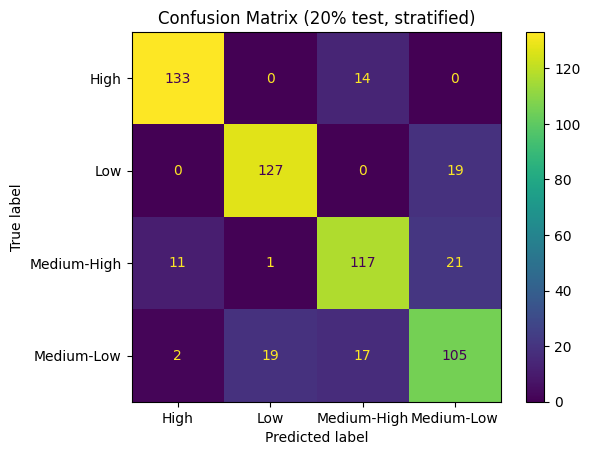

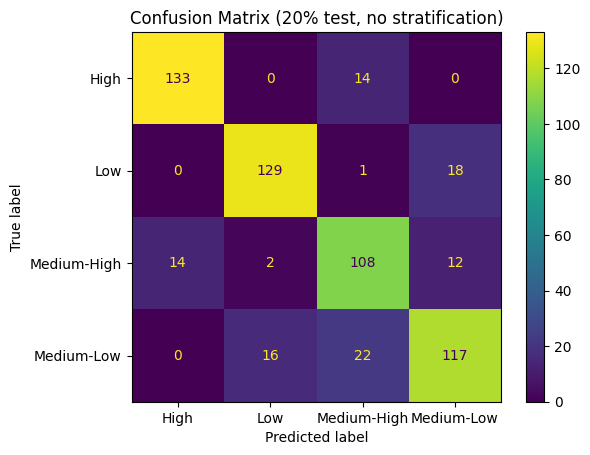

In [81]:
ConfusionMatrixDisplay.from_predictions(
    y_test_20, y_pred_20_strat,
    display_labels=y_encoder.classes_
)
plt.title('Confusion Matrix (20% test, stratified)')
plt.show()

ConfusionMatrixDisplay.from_predictions(
    y_test_20_no, y_pred_20_no_strat,
    display_labels=y_encoder.classes_
)
plt.title('Confusion Matrix (20% test, no stratification)')
plt.show()

In [82]:
from sklearn.model_selection import cross_validate, KFold

def train_and_evaluate(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_data = lgb.Dataset(X_train, y_train)
        
        model = lgb.train(params, train_data, num_boost_round=100)
        
        y_pred = np.argmax(model.predict(X_val), axis=1)
        
        scores.append({
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred, average='weighted'),
            'recall': recall_score(y_val, y_pred, average='weighted'),
            'f1': f1_score(y_val, y_pred, average='weighted')
        })
    
    return scores

X_np = X.to_numpy()
y_np = y_encoded

print("5-fold (unstratified) CV:")
cv5_scores = train_and_evaluate(X_np, y_np, 5)
metrics = ['accuracy', 'precision', 'recall', 'f1']
for metric in metrics:
    scores = [score[metric] for score in cv5_scores]
    print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

print("\n10-fold (unstratified) CV:")
cv10_scores = train_and_evaluate(X_np, y_np, 10)
for metric in metrics:
    scores = [score[metric] for score in cv10_scores]
    print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

5-fold (unstratified) CV:
accuracy: 0.7893 ± 0.0195
precision: 0.7935 ± 0.0182
recall: 0.7893 ± 0.0195
f1: 0.7900 ± 0.0192

10-fold (unstratified) CV:
accuracy: 0.7907 ± 0.0217
precision: 0.7938 ± 0.0209
recall: 0.7907 ± 0.0217
f1: 0.7910 ± 0.0214


In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_ohe = pd.get_dummies(X_cat, columns=categorical_cols, drop_first=True)

numeric_cols = X_ohe.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
if len(numeric_cols) > 0:
    X_ohe[numeric_cols] = scaler.fit_transform(X_ohe[numeric_cols])

idx = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y_encoded)

X_train_le = X.iloc[train_idx].reset_index(drop=True)
X_test_le = X.iloc[test_idx].reset_index(drop=True)

X_train_ohe = X_ohe.iloc[train_idx].reset_index(drop=True)
X_test_ohe = X_ohe.iloc[test_idx].reset_index(drop=True)

y_array = np.array(y_encoded)
y_train = y_array[train_idx]
y_test = y_array[test_idx]

print(f'Label-encoded features shape: {X_train_le.shape} -> {X_test_le.shape}')
print(f'One-hot features shape: {X_train_ohe.shape} -> {X_test_ohe.shape}')

train_le = lgb.Dataset(X_train_le, y_train)
model_le = lgb.train(params, train_le, num_boost_round=100)
y_pred_le = np.argmax(model_le.predict(X_test_le), axis=1)

train_ohe = lgb.Dataset(X_train_ohe, y_train)
model_ohe = lgb.train(params, train_ohe, num_boost_round=100)
y_pred_ohe = np.argmax(model_ohe.predict(X_test_ohe), axis=1)

def print_summary(name, y_true, y_pred):
    print('---', name, '---')
    print(f'Accuracy:  {accuracy_score(y_true, y_pred):.4f}')
    print(f'Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}')
    print(f'Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}')
    print(f'F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}')

print_summary('Label Encoding (LightGBM)', y_test, y_pred_le)
print_summary('One-Hot Encoding (LightGBM)', y_test, y_pred_ohe)


Label-encoded features shape: (2343, 55) -> (586, 55)
One-hot features shape: (2343, 196) -> (586, 196)
--- Label Encoding (LightGBM) ---
Accuracy:  0.8157
Precision: 0.8149
Recall:    0.8157
F1 Score:  0.8152
--- One-Hot Encoding (LightGBM) ---
Accuracy:  0.8003
Precision: 0.8022
Recall:    0.8003
F1 Score:  0.8011


In [84]:
param_grid = [
    {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.1},
    {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.05},
    {'max_depth': 6, 'n_estimators': 100, 'learning_rate': 0.1},
    {'max_depth': 9, 'n_estimators': 100, 'learning_rate': 0.1},
    {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.01},
    {'max_depth': 12, 'n_estimators': 100, 'learning_rate': 0.05},
]

for p in param_grid:
    clf_hp = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_encoded)),
        max_depth=p['max_depth'],
        learning_rate=p['learning_rate'],
        n_estimators=p['n_estimators'],
        random_state=42,
        metric='multi_logloss'
    )

    clf_hp.fit(X_train_20, y_train_20)
    y_pred_hp = clf_hp.predict(X_test_20)

    acc = accuracy_score(y_test_20, y_pred_hp)
    f1v = f1_score(y_test_20, y_pred_hp, average='weighted')
    rec = recall_score(y_test_20, y_pred_hp, average='weighted')
    prec = precision_score(y_test_20, y_pred_hp, average='weighted')

    print(
        f"max_depth={p['max_depth']}, n_estimators={p['n_estimators']}, "
        f"lr={p['learning_rate']} → acc={acc:.4f}, f1={f1v:.4f}, rec={rec:.4f}, prec={prec:.4f}"
    )


max_depth=3, n_estimators=50, lr=0.1 → acc=0.7816, f1=0.7801, rec=0.7816, prec=0.7794
max_depth=3, n_estimators=200, lr=0.05 → acc=0.8020, f1=0.8016, rec=0.8020, prec=0.8013
max_depth=6, n_estimators=100, lr=0.1 → acc=0.8191, f1=0.8187, rec=0.8191, prec=0.8186
max_depth=9, n_estimators=100, lr=0.1 → acc=0.8123, f1=0.8111, rec=0.8123, prec=0.8104
max_depth=6, n_estimators=200, lr=0.01 → acc=0.7969, f1=0.7961, rec=0.7969, prec=0.7956
max_depth=12, n_estimators=100, lr=0.05 → acc=0.8106, f1=0.8116, rec=0.8106, prec=0.8132


The model achieves the best performance with hyperparameters set to max_depth = 6, n_estimators = 100, and learning rate = 0.1. This configuration provides the most effective balance between model complexity and generalization.

Models with a shallower depth show lower accuracy, indicating underfitting. On the other hand, deeper trees slightly reduce performance, suggesting that excessive depth may cause the model to overfit to training data.

The learning rate of 0.1 appears optimal, allowing the model to converge effectively without overshooting. Reducing the learning rate to 0.05 or 0.01 did not yield better results.

Overall, the combination of moderate tree depth, a sufficient number of estimators, and a balanced learning rate enables the model to learn complex relationships while maintaining good generalization and avoiding both underfitting and overfitting.
